# Рекомендация тарифов

Есть данные о клиентах телефонной компании Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Целевой метрикой является 'accuracy'

In [1]:
#common imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import joblib
import pandas as pd

import seaborn as sns

## 1. Откройте и изучите файл

In [2]:
df=pd.read_csv('datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
df.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


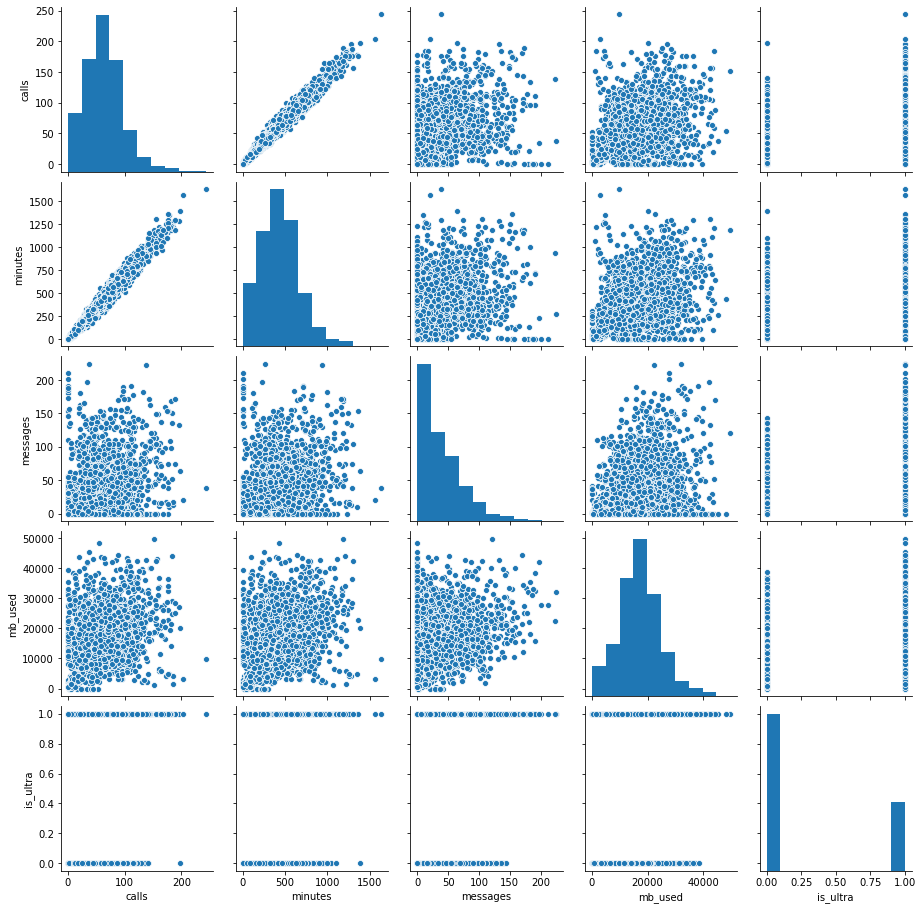

In [6]:
sns.pairplot(df)

**Вывод**: Так как данные уже прошли предобработку, то пустых значений нет. Из парного графика видно, что большинство данных распределны равномерно, за исключением messages, так как там распределение смещено влево

## 2. Разбейте данные на выборки

In [7]:
#Устанавливаем размеры выборок
size=[3,1,1]
train_size=int((size[0]/sum(size))*len(df))
val_size=int(((size[0]+size[1])/sum(size))*len(df))
test_size=int(((size[0]+size[1]+size[2])/sum(size))*len(df))

#Делим выборку
train=df[:train_size]
val=df[train_size:val_size]
test=df[val_size:test_size]
#Для финального обучения
train_val=df[:val_size]

In [8]:
def features_target_split(df):
    features=df.drop(['is_ultra'], axis=1)
    target=df['is_ultra']
    return features,target

In [9]:
#Выделяем признаки и цели
train_features, train_target=features_target_split(train)
val_features, val_target=features_target_split(val)
test_features, test_target=features_target_split(test)
train_val_features, train_val_target=features_target_split(train_val)

**Вывод**: разбиение данных осуществляется путём разделения исходного набора данных в пропорциях 3:1:1 (или 60%:20%:20%). Также создаётся специальный DataFrame в котором хранятся объекдинённые данные из наборов для обучения и валидационного. Этот объединённый DataFrame будем использовать при обучении финальной модели, чтобы повысить точность обобщающей способности модели

## 3. Исследуйте модели

In [10]:
#Для поиска
statistics=pd.DataFrame(columns=['type',"test_accuracy", "val_accuracy"])
max_accuracy_train=0
max_accuracy_val=0

In [11]:
def find_model(name_model, model):
    global best_model, max_accuracy_train, statistics
    model.fit(train_features, train_target)
    accuracy=model.score(train_features,train_target)
    if accuracy>max_accuracy_train:
        #Защита от переобучения
        val_accuracy=model.score(val_features,val_target)
        delta=((val_accuracy-accuracy)**2)**0.5
        if delta<0.2:
            if delta>0.1:
                max_accuracy_train=val_accuracy
            else:  
                max_accuracy_train=accuracy
            stat=pd.Series([name_model,accuracy,val_accuracy], index=statistics.columns)
            statistics=statistics.append(stat, ignore_index=True)

In [12]:
#Используем логистическую регрессию
model=LogisticRegression(random_state=12345)
find_model("логистическая регрессия",model)

In [13]:
#Используем случайный лес
for est in range(1,100,1):
    model=RandomForestClassifier(n_estimators=est, random_state=12345)
    find_model("Случайный лес ({})".format(est),model)

In [14]:
#Используем решающее дерево
for depth in range(1,100,1):
    model=DecisionTreeClassifier(max_depth=depth, random_state=12345)
    find_model("Decision tree ({})".format(depth),model)

In [15]:
statistics.sort_values('val_accuracy',ascending=False).head(50)

,type,test_accuracy,val_accuracy
77,Случайный лес (79),0.999481,0.813375
102,Decision tree (9),0.857365,0.813375
71,Случайный лес (73),1.000000,0.813375
45,Случайный лес (47),1.000000,0.811820
101,Decision tree (8),0.843361,0.811820
100,Decision tree (7),0.834025,0.811820
30,Случайный лес (32),0.997925,0.811820
41,Случайный лес (43),1.000000,0.811820
43,Случайный лес (45),1.000000,0.810264
69,Случайный лес (71),1.000000,0.810264


**Вывод**: модель случайного леса даёт большое переобучение, поэтому в рамках текущего проекта будем использовать Decision Tree. Наибольшую точность показывает модель с глубиной, равной 9

## 4. Проверьте модель на тестовой выборке

In [16]:
model=DecisionTreeClassifier(max_depth=9, random_state=12345)
model.fit(train_val_features, train_val_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=12345, splitter='best')

In [17]:
#Точность на обучающем наборе
model.score(train_val_features, train_val_target)

0.8580318942045897

In [18]:
#Точность на тестовом наборе
model.score(test_features, test_target)

0.7838258164852255

**Вывод**: После обучения модели на объединённом ноборе данных (test+val) обобщающая способность модели на тестовом наборе превышает 75%, что свидетельствует о том, что данная модель удовлетворяет представленным требованиям

## 5. (бонус) Проверьте модели на адекватность

In [33]:
#Ответы модели не связаны с правильными ответами, поэтому вероятность угадать «1» равна 0.5
smart_count=sum(test_target==0)
ultra_count=sum(test_target==1)
probability=0.5

random_accuracy=(smart_count*smart_count/len(test_target)*probability+
                 ultra_count*ultra_count/len(test_target)*probability)/len(test_target)
random_accuracy

0.288094783153424

**Вывод**: вероятность случайно угадать тариф равна 29%, что существенно ниже, чем обобщающая способность модели, следовательно, модель адекватна

## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
